In [1]:
import jax
import jax.numpy as jnp 
import jax.random as jr
import optax

import sbgm

Here we're going to train a score-based diffusion model to generate log-normal random fields $\boldsymbol{x}$ conditioned on Gaussian random fields $\boldsymbol{q}$ and power spectrum parameters $\alpha$.

The power spectrum that generates the Gaussian field is given by $P(k)=A\times k^B$, where $\alpha=(A,B)$.

This is a rough analogy to late time matter density fields in the Universe.

In [2]:
# Load (data) and save (model, samples & optimiser state) directories 
datasets_path = "../datasets/"
root_dir = "./"

n_devices = len(jax.devices())

In [3]:
key = jr.key(0)

data_key, model_key, train_key = jr.split(key, 3)

# Data
dataset_name          = "cifar10" 
n_pix                 = 32
n_channels            = 3  
img_shape             = (n_channels, n_pix, n_pix)
parameter_dim         = 1 

# Model
is_biggan             = False
dim_mults             = [1, 1, 1]
hidden_size           = 64
heads                 = 4
dim_head              = 64
dropout_rate          = 0.1
num_res_blocks        = 2
attn_resolutions      = [8, 16, 32]
final_activation      = None

# SDE
t1                    = 8.
t0                    = 0.
dt                    = 0.1
beta_integral         = lambda t: t 
weight_fn             = lambda t: 1. - jnp.exp(-beta_integral(t)) 

# Sampling
use_ema               = False
sample_size           = 5 # Squared for a grid
exact_logp            = False
ode_sample            = True # Sample the ODE during training
eu_sample             = True # Euler-Maruyama sample the SDE during training

# Optimisation hyperparameters
start_step            = 0
n_steps               = 1_000_000
batch_size            = 64 * n_devices
accumulate_gradients  = True
n_minibatches         = 4
sample_and_save_every = 1_000
lr                    = 3e-4
opt                   = optax.adamw
opt_kwargs            = {} 

We will generate a Gaussian random field and a log-nornal field given a set of power spectrum parameters we sample from a uniform prior.

In [4]:
from data import cifar10 

# Dataset object of training data and loaders
dataset = cifar10(datasets_path, data_key, in_memory=True)

Files already downloaded and verified
Files already downloaded and verified


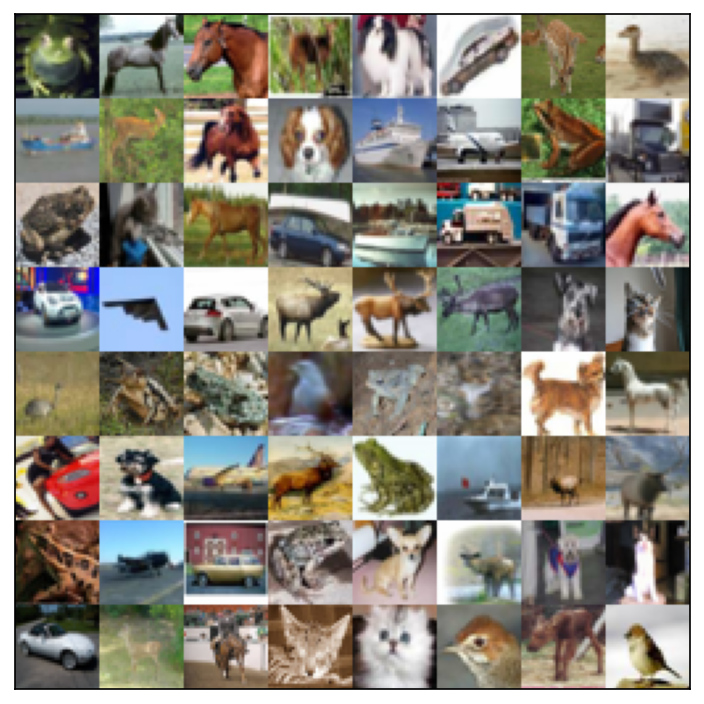

In [5]:
from einops import rearrange 
import matplotlib.pyplot as plt

n_plot = 8 # Grid side length in images
cmap = "coolwarm"

# Grab a batch to plot from the dataloader
X, _, A = next(dataset.train_dataloader.loop(n_plot ** 2))

# Reverse process the data
X = dataset.process_fn.reverse(X)

fig, ax = plt.subplots(dpi=150)
ax.imshow(
    rearrange(X, "(h w) c x y -> (h x) (w y) c", h=n_plot, w=n_plot, x=n_pix, y=n_pix)
)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

This example is run with multiple GPU accelerators (you may have to reduce the batch size or model parameters without them).

In [6]:
# Multiple GPU training if you are so inclined
sharding, replicated_sharding = sbgm.shard.get_shardings()

Running on 4 local devices: 
	[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]


We'll use a UNet with an multihead-attention mechanism and time conditioning. Pretty standard for generative models.

In [7]:
from sbgm.models import UNet

# Diffusion model 
model = UNet(
    dim=hidden_size,
    channels=n_channels,
    dim_mults=dim_mults,
    attn_heads=heads,
    attn_dim_head=dim_head,
    dropout=dropout_rate,
    learned_sinusoidal_cond=True,
    random_fourier_features=True,
    a_dim=parameter_dim, # CIFAR10 class variable
    key=model_key
)

Here is our stochastic differential equation (SDE) which describes how we perturb our fields with noise.

You can see an example of diffusing a log-normal field here. The colourmap is restricted to the data pixel values (hence the blank pixels).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.047970485..0.9254902].


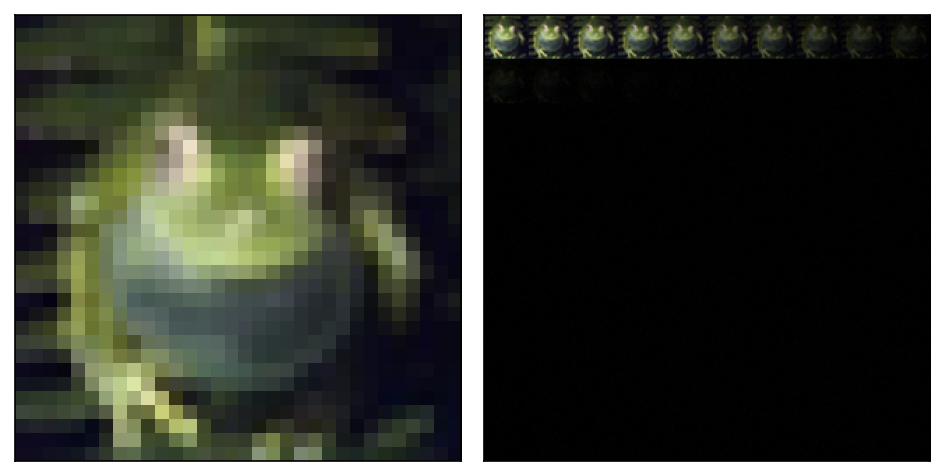

In [8]:
from sbgm.sde import VPSDE

# Stochastic differential equation (SDE)
sde = VPSDE(
    beta_integral_fn=beta_integral,
    dt=dt,
    t0=t0, 
    t1=t1,
    weight_fn=weight_fn
)

def diffuse(x, t, eps):
    mu, std = sde.marginal_prob(x, t)
    return mu + std * eps
    
n_side = 10
n_t = 100
times = jnp.linspace(t0, t1, n_t)

imgs = [X[0]]
for i, t in enumerate(times):
    key_i = jr.fold_in(key, i)

    eps = jr.normal(key_i, img_shape) * 0.01 # Illustration purposes!

    Xt = diffuse(imgs[i], t, eps)

    imgs.append(Xt)

fig, axs = plt.subplots(1, 2, dpi=150)
ax = axs[0]
ax.imshow(imgs[0].transpose(1, 2, 0), cmap=cmap)
ax = axs[1]
ax.imshow(
    rearrange(imgs[1:], "(h w) c x y -> (h x) (w y) c", h=10, w=10, x=n_pix, y=n_pix)
)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
## Fit model to dataset
model = sbgm.train.train(
    train_key,
    model,
    sde,
    dataset,
    opt=opt(lr, **opt_kwargs),
    n_steps=n_steps,
    batch_size=batch_size,
    accumulate_gradients=accumulate_gradients,
    n_minibatches=n_minibatches,
    sample_size=sample_size,
    eu_sample=eu_sample,
    ode_sample=ode_sample,
    reload_opt_state=False,
    plot_train_data=True,
    sharding=sharding,
    replicated_sharding=replicated_sharding,
    save_dir=root_dir,
    cmap=cmap
)

Training SGM with a VPSDE on cifar10 dataset.


  0%|          | 0/1000000 [00:00<?, ?it/s]

Now we can calculate the likelihood of a log-normal map given a Gaussian field and $P(k)$ parameterisation. 

In [ ]:
from sbgm._ode import get_log_likelihood_fn

log_likelihood_fn = get_log_likelihood_fn(
    model, sde, dataset.data_shape, exact_logp=False, n_eps=64
)
L_X = log_likelihood_fn(X[0], Q[0], A[0], key)

L_X